In [ ]:
# Reseteamos todas las variables de entorno
# %reset

# IMPORT LIBRARIES

# Processing
import librosa
import librosa.display
import numpy as np
import random
from tqdm import tqdm

# Visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import IPython.display as ipd
import cv2
from PIL import Image

# Files
import os
import joblib
import pickle

# Machine Learning
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.metrics import confusion_matrix
import keras
from keras.utils import np_utils
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Reshape
import tensorflow as tf

# ####### TEST ####### 
# Scipy
from scipy import signal
from scipy.io import wavfile

## **CONFIGURACION DEL ENTORNO**

Configuramos el entorno para que nos deje acceder a los archivos e importar los módulos de python.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys  
GPATH = '/content/drive/My Drive/Master/Asignaturas/2 Cuatrimestre/Proyecto/Code/'

if GPATH + '/SpeechEmotionRecognition' in sys.path:
  sys.path.remove(GPATH + '/SpeechEmotionRecognition')

sys.path.insert(0, GPATH + '/SpeechEmotionRecognition')

## **1. DATOS**

In [ ]:
# Caracteristicas
FEATURES_PATH = GPATH + 'SpeechEmotionRecognition/data/processed/features/'
FIGURES_PATH = GPATH + 'SpeechEmotionRecognition/reports/figures/'

# Datasets
SAVEE_PATH = GPATH + 'data/SAVEE/'
TESS_PATH = GPATH + 'data/TESS/'
RAVDESS_PATH = GPATH + 'data/RAVDESS/'

# Spectrogramas
SPECT_IMG = GPATH + 'data/spectrograms/'

# Maps
EMOTION_MAP = {4:'neutral', 3:'happy', 5:'sad', 0:'angry', 2:'fear', 1:'disgust', 6:'surprise'}
INTENSITY_MAP = {1:'normal', 2:'strong'}

### **1.1 CARGA DE LOS DATOS**

#### **1.1.1 DATASET SAVEE**

In [ ]:
# Leemos SAVEE

emotion=[]
path = []

for dir in os.listdir(SAVEE_PATH):
  path_dir = os.listdir(SAVEE_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filename in path_dir:
    str_path = SAVEE_PATH + dir + '/' + str(filename)
    path.append(str_path)
    if(filename[0]=='a'):
        emotion.append("angry")
    elif(filename[0]=='h'):
        emotion.append("happy")
    elif(filename[0]=='f'):
        emotion.append("fear")
    elif(filename[0]=='d'):
        emotion.append("disgust")
    elif(filename[0]=='n'):
        emotion.append('neutral')
    elif(filename[0]=='s'):
        if(filename[1]=='a'):
            emotion.append("sad")
        elif(filename[1]=='u'):
            emotion.append("surprise")


SAVEE_df = pd.DataFrame(columns=['emotion', 'path'])
SAVEE_df['emotion'] = emotion
SAVEE_df['path'] = path

SAVEE_df['emotion'].unique()

array(['angry', 'disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise'],
      dtype=object)

In [ ]:
SAVEE_df.sample(5)

,emotion,path
384,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
444,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
217,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
166,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
50,fear,/content/drive/My Drive/Master/Asignaturas/2 C...


#### **1.1.2 DATASET TESS**

In [ ]:
# Leemos TESS

emotion=[]
path = []

for dir in os.listdir(TESS_PATH):
  path_dir = os.listdir(TESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  label = dir.split('_')[1]
  for filename in path_dir:
    str_path = TESS_PATH + dir + '/' + str(filename)
    path.append(str_path)
    emotion.append(label.lower())


TESS_df = pd.DataFrame(columns=['emotion', 'path'])
TESS_df['emotion'] = emotion
TESS_df['path'] = path

print( "Size of the dataset: {} \n".format(len(TESS_df)) )
TESS_df.sample(5)

Size of the dataset: 2800 



,emotion,path
209,fear,/content/drive/My Drive/Master/Asignaturas/2 C...
1394,disgust,/content/drive/My Drive/Master/Asignaturas/2 C...
444,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
1716,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
1524,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...


In [ ]:
TESS_df['emotion'].unique()

array(['sad', 'fear', 'happy', 'neutral', 'angry', 'disgust', 'surprise'],
      dtype=object)

#### **1.1.3 DATASET RAVDESS**

In [ ]:
emotion = []
path = []

# Extraemos de cada archivo de sonido sus datos
for dir in os.listdir(RAVDESS_PATH):
  path_dir = os.listdir(RAVDESS_PATH + dir) # todos los archivos de audios asociados a un directorio
  for filepath in path_dir:
    info_vector = filepath.split('.')[0].split('-')
    n_emotion = int(info_vector[2])
    str_path = RAVDESS_PATH + dir + '/' + str(filepath)
    path.append(str_path)
    emotion.append(n_emotion)


# Construimos el data frame
RAVDESS_df = pd.DataFrame(columns=['emotion', 'path'])
RAVDESS_df['emotion'] = emotion
RAVDESS_df['path'] = path
RAVDESS_df['emotion'] = RAVDESS_df['emotion'].map(EMOTION_MAP) 

RAVDESS_df.sample(5)

,emotion,path
1173,surprise,/content/drive/My Drive/Master/Asignaturas/2 C...
673,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
738,happy,/content/drive/My Drive/Master/Asignaturas/2 C...
503,neutral,/content/drive/My Drive/Master/Asignaturas/2 C...
454,sad,/content/drive/My Drive/Master/Asignaturas/2 C...


In [ ]:
print( "Size of the dataset: {} \n".format(len(RAVDESS_df)) )
print( RAVDESS_df['emotion'].value_counts() )

Size of the dataset: 1440 

fear        192
sad         192
neutral     192
surprise    192
happy       192
disgust      96
Name: emotion, dtype: int64


Para que todas las emociones coincidan con el resto de datasets, vamos a eliminar calm

In [ ]:
RAVDESS_df['emotion'].unique()
RAVDESS_df = RAVDESS_df[RAVDESS_df['emotion'] != 'calm']
RAVDESS_df['emotion'].unique()

array(['disgust', 'fear', 'happy', 'neutral', 'sad', 'surprise', nan],
      dtype=object)

### **1.2 EXTRACCION DE ESPECTROGRAMAS**

In [ ]:
from src.MFCC import MFCC

In [ ]:
def generate_spectrograms(df, name, output_path):
  '''
  Genera y almacena espectogramas unas caracteristicas espeficicas
  Aguments
  ---------
  df: DataFrame
    dataframe donde estan almacenados los datos

  output_path: str
    Ruta donde se almacenaran los archivos generados

  '''

  bar_data_range = tqdm(range(len(df)))
  data = pd.DataFrame(columns = ['data'])
  
  for index in bar_data_range:
    save_mfccspectrograma(df.path[index], name, df.emotion[index] , output_path, index)


def save_mfccspectrograma(pathfile, name, emotionName, output_path, index):
  '''
  Genera un espectograma MFCC como imagen a partir de un archivo, y lo guarda en una ruta especificada
  Aguments
  ---------
  pathfile: str
    Ruta donde se encuentra el archivo.

  output_path: str
    Ruta donde se guardara la imagen generada.
  '''
  X, sample_rate = librosa.load(pathfile, res_type='kaiser_fast')
  features_mfccspectrogram = librosa.feature.mfcc(X, sr=sample_rate, n_mfcc=20)
  fig = plt.figure(figsize=(12,4))
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  librosa.display.specshow(features_mfccspectrogram, sr=sample_rate, x_axis='time', y_axis='mel')

  filename = output_path + emotionName + "/" + name + "_mfccspectrogram_" + str(index)+".jpg"
  if not os.path.exists(output_path + emotionName):
    os.makedirs(output_path + emotionName)

  plt.savefig(filename, bbox_inches='tight', transparent=True, pad_inches=-0.05)
  plt.close()



def load_spectograms_dataset(path, dimensions, verbose=True):
  '''
  Devuelve un dataframe con las imágenes generadas que se usarán tanto en el entrenamiento 
  como en test. Asume que en el path especificado existen esos archivos.
  
  Arguments:
  ----------
    path: str
      Directorio donde se encuentran las imagenes
    mfcc: boolean
      Especifica si se añaden los espectogramas MFCC al dataset
    mel: boolean
      Especifica si se añaden los espectogramas de MEL al dataset
    classes: dictionary
      Categorias a las que pertenecen las imagenes
    verbose: boolean
      Especifica si se activan los mensajes mientras se leen las imagenes

  Returns:
  ----------
  '''
  list_images = []
  labels = []

  mfcc_img, mfcc_lb = load_images(path, dimensions, os.listdir(path))
  list_images.extend(mfcc_img)
  labels.extend(mfcc_lb)

  return list_images, labels



def load_images(path, dimensions, classes, verbose=True):

  '''
  Lee las imágenes que se cargarán desde un determinado directorio
  Arguments:
  ----------
    path: str
      Directorio donde se encuentran las imagenes
    classes: dictionary
      Categorias a las que pertenecen las imagenes
    verbose: boolean
      Especifica si se activan los mensajes mientras se leen las imagenes

  Returns:
  ----------
  '''
  list_images = []
  labels = []
  for index, emotion in enumerate(classes):
    emodir = os.path.join(path, emotion)
    files = os.listdir(emodir)
    images = [file for file in files if file.endswith("jpg")]
    if verbose:
      print("Leídas {} espectogramas pertenecientes a {}".format(len(images), emotion))
    for image_name in images:
      image = cv2.imread(os.path.join(emodir, image_name))
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      img_arr = Image.fromarray(image, 'RGB')
      resized_img = img_arr.resize((dimensions[0], dimensions[1])) 

      list_images.append(np.array(resized_img))
      labels.append(index)

  return list_images, labels

In [ ]:
features_spectMFCC_SAVEE = MFCC(df_data = SAVEE_df, dataset_name = "SAVEE")
features_spectMFCC_RAVDESS = MFCC(df_data = RAVDESS_df, dataset_name = "RAVDESS")
features_spectMFCC_TESS = MFCC(df_data = TESS_df, dataset_name = "TESS")

In [ ]:
# Genero los espectrogramas
# features_spectMFCC_SAVEE.generate_spectrograms(SPECT_IMG)
# features_spectMFCC_RAVDESS.generate_spectrograms(SPECT_IMG)
# features_spectMFCC_TESS.generate_spectrograms(SPECT_IMG)


In [ ]:
list_images_savee_tess, labels = load_spectograms_dataset(SPECT_IMG + 'mfcc_savee_tess/', (30, 40))

Leídas 460 espectogramas pertenecientes a angry
Leídas 460 espectogramas pertenecientes a disgust
Leídas 460 espectogramas pertenecientes a fear
Leídas 460 espectogramas pertenecientes a happy
Leídas 524 espectogramas pertenecientes a neutral
Leídas 460 espectogramas pertenecientes a sad
Leídas 460 espectogramas pertenecientes a surprise


In [ ]:
# Barajamos aleatoriamente 
array_images_savee_tess = np.array(list_images_savee_tess)
perm = np.random.permutation(len(list_images_savee_tess))
array_images_savee_tess, labels = array_images_savee_tess[perm], np.array(labels)[perm]

# Comprobamos las dimensiones
print("{} imagenes con dimension {}".format(array_images_savee_tess.shape[0], array_images_savee_tess.shape[1:]))

3284 imagenes con dimension (40, 30, 3)


## **2. DEFINICION DEL MODELO**

In [ ]:
def get_model_2D_CNN(shape, classes): # Ganador
  model=Sequential()
  model.add(Conv2D(32,(4,10),input_shape=shape, activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(4,10),activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Conv2D(32,(4,10),activation='relu',padding='same'))
  model.add(MaxPooling2D(3,3))
  model.add(Dropout(0.2))

  model.add(Flatten())
  model.add(Dense(classes, activation='softmax'))
 
  return model


def get_model_LSTM_CNN(shape, classes):
  model = Sequential()

  # 1 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = shape, activation = 'relu')) # (128, 128, 3)
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 2 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # 3 Capa CNN 2D
  model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
  model.add(MaxPooling2D(pool_size = (2, 2)))

  # Capa Flatten
  model.add(Flatten())
  model.add(Dropout(rate = 0.5))

  # Capas LSTM 1D
  model.add(Reshape((1, 960))) 
  model.add(LSTM(units = 50, return_sequences = True, dropout = 0.5))
  model.add(LSTM(units = 20, return_sequences = False, dropout = 0.5))

  model.add(Dense(classes, activation = 'softmax'))

  return model

# # DEPRECATED
# def get_model_B(shape, n_classes): # Este es mi modelo antiguo probado n x 10000 veces en RAVDESS
#   model = Sequential()

#   # Step 1 - Convolution
#   model.add(Conv2D(64, (3, 3), padding = 'same', input_shape = shape, activation = 'relu'))
#   model.add(MaxPooling2D(pool_size = (2, 2)))

#   # Adding a second convolutional layer
#   model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
#   model.add(MaxPooling2D(pool_size = (2, 2)))

#   # # Adding a third conolutional layer
#   # model.add(Conv2D(64, (3, 3), padding = 'same', activation = 'relu'))
#   # model.add(MaxPooling2D(pool_size = (2, 2)))

#   # Step 3 - Flattening
#   model.add(Flatten())
#   model.add(Dropout(0.5))

#   # Step 4 - Full connection
#   model.add(Dense(128, 'relu'))
#   model.add(Dropout(0.5))
#   model.add(Dense(7, 'softmax'))

#   return model


def plot_loss_acc(history):
  # Mostramos la grafica loss 
  fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
  ax1.plot(history.history['loss'])
  ax1.plot(history.history['val_loss'])
  ax1.set_title('Loss')
  ax1.set(xlabel='epoch', ylabel='loss')
  ax1.legend(['train', 'test'], loc='upper right')

  # Mostramos la grafica accuracy
  ax2.plot(history.history['accuracy'])
  ax2.plot(history.history['val_accuracy'])
  ax2.set_title('Validation')
  ax2.set(xlabel='epoch', ylabel='acc')

  ax2.legend(['train', 'test'], loc='lower right')

## **3. PROCESAMIENTO DE LOS DATOS**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(array_images_savee_tess, labels, test_size=0.25, shuffle=True, random_state=42)

In [ ]:
# one hot encoding 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

In [ ]:
print("La clase {} categorizada: {}".format(2, y_train[2]))

La clase 2 categorizada: [0. 0. 0. 0. 0. 0. 1.]


In [ ]:
print("Entrenamiento: Datos con dimension {}, y clases con {}".format(X_train.shape, y_train.shape))
print("Test: Datos con dimension {}, y clases con {}".format(X_test.shape, y_test.shape))


Entrenamiento: Datos con dimension (2463, 40, 30, 3), y clases con (2463, 7)
Test: Datos con dimension (821, 40, 30, 3), y clases con (821, 7)


## **4. PRUEBAS**

### **4.1 TESS + RAVDESS**

### **4.2 TESS + SAVEE**
A continuación, pr

#### **4.2.1 MODELO REDES CONVOLUCIONALES**


##### **ENTRENAMIENTO**

In [ ]:
modelA = get_model_2D_CNN(X_train.shape[1:], y_train.shape[1])
# plot_model(modelA, to_file=FIGURES_PATH + 'model_cnn2d.png', show_shapes=True, show_layer_names=True)
modelA.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 40, 30, 32)        3872      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 13, 10, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 13, 10, 32)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 13, 10, 32)        40992     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 4, 3, 32)          0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 4, 3, 32)          0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 4, 3, 32)         

In [ ]:
modelA.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
historyA = modelA.fit(X_train, y_train, 
                      batch_size=32, 
                      epochs=100, 
                      validation_data=(X_test, y_test))

52/52 [==============================] - 1s 14ms/step - loss: 0.2658 - accuracy: 0.9208
Loss: 0.2657979428768158 
Accuracy: 92.08282828330994%


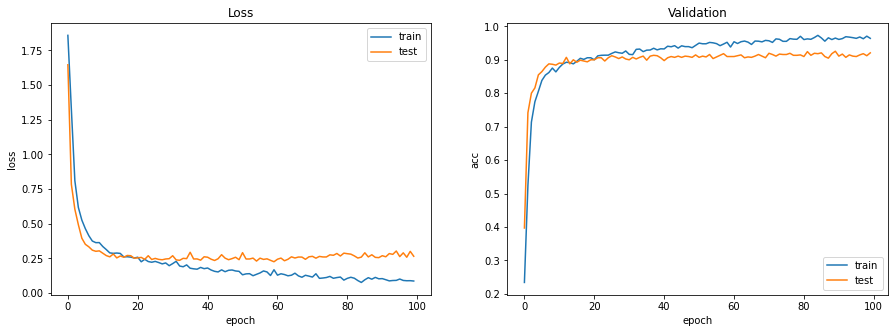

In [ ]:
plot_loss_acc(historyA)
# Evaluamos contra test
score = modelA.evaluate(X_test, y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

##### **EVALUACIÓN**

In [ ]:
from sklearn.metrics import classification_report

predicted_y = modelA.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(y_test, axis=1)

# # Mapeo con el nombre de las clases
# X, Y = processed_savee_tess_ravdess.get_categorical_classes()
# mapping = dict(zip(categorical_labels, Y))

# Mapeo el nombre de las clases
predicted_y = list(map(EMOTION_MAP.get, predicted_y))
categorical_labels = list(map(EMOTION_MAP.get, categorical_labels))

In [ ]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.75      0.98      0.85        98
     disgust       0.96      0.86      0.91       128
        fear       0.95      0.90      0.92       101
       happy       0.94      0.89      0.91       118
     neutral       0.89      0.98      0.93       129
         sad       0.99      0.90      0.94       136
    surprise       0.96      0.92      0.94       111

    accuracy                           0.92       821
   macro avg       0.92      0.92      0.92       821
weighted avg       0.92      0.92      0.92       821



Prueba con el modelo B

In [ ]:
# modelB = get_model_B(X_train.shape[1:], y_train.shape[1])
# modelB.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
# historyB = modelB.fit(X_train, y_train, 
#                       batch_size=32, 
#                       epochs=100, 
#                       validation_data=(X_test, y_test))



In [ ]:
# plot_loss_acc(historyB)
# # Evaluamos contra test
# score = modelB.evaluate(X_test, y_test, batch_size=16)
# print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

#### **4.2.1 MODELO REDES LSTM + CONVOLUCIONALES**

##### **ENTRENAMIENTO**

In [ ]:
model_lstm = get_model_LSTM_CNN(X_train.shape[1:], y_train.shape[1])
# plot_model(model_lstm, to_file=FIGURES_PATH + 'model_lstm_cnn2d.png', show_shapes=True, show_layer_names=True)
model_lstm.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 40, 30, 64)        1792      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 20, 15, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 20, 15, 64)        36928     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 10, 7, 64)         0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 10, 7, 64)         36928     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 5, 3, 64)          0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 960)              

In [ ]:
model_lstm.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
history_lstm = model_lstm.fit(X_train, y_train, 
                      batch_size=32, 
                      epochs=100, 
                          validation_data=(X_test, y_test))

Epoch 1/100
77/77 [==============================] - 16s 149ms/step - loss: 1.9343 - accuracy: 0.1716 - val_loss: 1.8291 - val_accuracy: 0.3423
Epoch 2/100
77/77 [==============================] - 10s 133ms/step - loss: 1.8467 - accuracy: 0.2822 - val_loss: 1.5518 - val_accuracy: 0.5700
Epoch 3/100
77/77 [==============================] - 10s 132ms/step - loss: 1.6170 - accuracy: 0.3972 - val_loss: 1.1218 - val_accuracy: 0.6931
Epoch 4/100
77/77 [==============================] - 10s 132ms/step - loss: 1.2536 - accuracy: 0.5825 - val_loss: 0.8850 - val_accuracy: 0.7430
Epoch 5/100
77/77 [==============================] - 10s 133ms/step - loss: 1.0050 - accuracy: 0.6800 - val_loss: 0.6752 - val_accuracy: 0.8039
Epoch 6/100
77/77 [==============================] - 10s 134ms/step - loss: 0.8720 - accuracy: 0.7170 - val_loss: 0.5982 - val_accuracy: 0.8136
Epoch 7/100
77/77 [==============================] - 10s 132ms/step - loss: 0.7321 - accuracy: 0.7626 - val_loss: 0.5143 - val_accuracy:

52/52 [==============================] - 1s 17ms/step - loss: 0.2551 - accuracy: 0.9074
Loss: 0.25507551431655884 
Accuracy: 90.74299931526184%


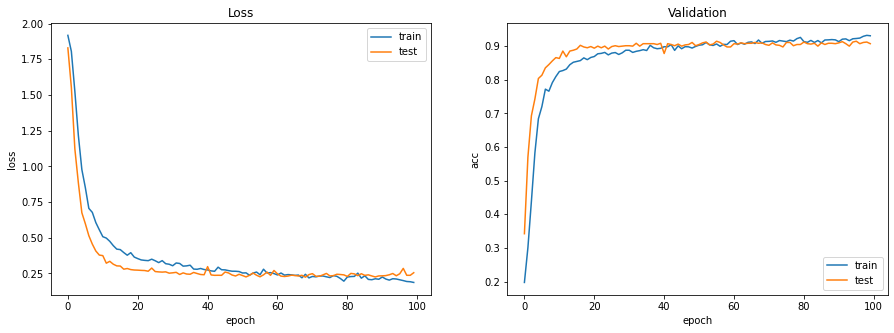

In [ ]:
plot_loss_acc(history_lstm)
# Evaluamos contra test
score = model_lstm.evaluate(X_test, y_test, batch_size=16)
print("Loss: {} \nAccuracy: {}%".format(score[0], score[1]*100))

##### **EVALUACION**

In [ ]:
from sklearn.metrics import classification_report

predicted_y = model_lstm.predict(X_test)
predicted_y = np.argmax(np.round(predicted_y),axis=1)

categorical_labels = np.argmax(y_test, axis=1)

# Mapeo el nombre de las clases
predicted_y = list(map(EMOTION_MAP.get, predicted_y))
categorical_labels = list(map(EMOTION_MAP.get, categorical_labels))

In [ ]:
print(classification_report(categorical_labels, predicted_y))

              precision    recall  f1-score   support

       angry       0.69      0.99      0.81       106
     disgust       1.00      0.91      0.95       123
        fear       0.92      0.92      0.92       126
       happy       0.98      0.88      0.93       113
     neutral       0.88      0.89      0.89       129
         sad       0.96      0.84      0.90       115
    surprise       0.99      0.88      0.93       109

    accuracy                           0.90       821
   macro avg       0.92      0.90      0.90       821
weighted avg       0.92      0.90      0.91       821



### **4.3 TESS + RAVDESS + SAVEE**